In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'bigquery-ethereum-403902' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=bigquery-ethereum-403902:US:bquxjob_679c04ce_18c5aea251c)
back to BigQuery to edit the query within the BigQuery user interface.

In [176]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_26dfd6a_18c5b6a264c') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT
  EXTRACT(YEAR FROM block_timestamp) as year,
  EXTRACT(MONTH FROM block_timestamp) as month,
  EXTRACT(DAY FROM block_timestamp) as day,
  SUM(IF(transaction_type <> 2, 1, 0)) as sum_legacy,
  SUM(gas) as sum_gas,
  SUM(gas_price / 1E18) as sum_gas_price,
  SUM(value / 1E18) as sum_value,
  COUNT(*) as transaction_count
FROM bigquery-public-data.goog_blockchain_ethereum_mainnet_us.transactions t
WHERE block_timestamp >= '2020-01-01'
GROUP BY 1, 2, 3
ORDER BY 1, 2, 3


# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [177]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_26dfd6a_18c5b6a264c') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results

,year,month,day,sum_legacy,sum_gas,sum_gas_price,sum_value,transaction_count
0,2020,1,1,466526,99315663153,0.005436,617910.69774173993527880500000000000000000000,466526
1,2020,1,2,505639,105497322435,0.005334,1118306.89527247445495710100000000000000000000,505639
2,2020,1,3,581641,133692642038,0.006664,1852352.39390362507834020800000000000000000000,581641
3,2020,1,4,559074,139366939585,0.005391,1132515.06488927352221812000000000000000000000,559074
4,2020,1,5,524664,121765425803,0.005101,900666.14906663657530625600000000000000000000,524664
...,...,...,...,...,...,...,...,...
1437,2023,12,8,173897,324161222397,0.056041,1412774.72503602906668629300000000000000000000,1182465
1438,2023,12,9,176196,342004492773,0.042918,852222.04998427171482051800000000000000000000,1120555
1439,2023,12,10,169887,324175505065,0.043003,793035.31084833553344565000000000000000000000,1129096
1440,2023,12,11,177010,322107881499,0.045148,1648920.24997576846492310700000000000000000000,1087662


In [178]:
results['date'] = results.apply(lambda row: str(row['year']) + '-' + ('0' + str(row['month']))[-2:] + '-' + ('0' + str(row['day']))[-2:], axis=1)

In [204]:
results = results.loc[0:len(results) - 2]

In [183]:
results['sum_value'] = results['sum_value'].apply(float)

In [180]:
import numpy as np
import matplotlib.pyplot as plt

def show_metric(metric, title='', moving_average=False, label_height=0.75):
  TICK_SIZE = 50
  N = 30
  DATES = ['2022-05-01', '2022-07-31', '2023-05-01', '2023-07-31']

  ticks = [i * TICK_SIZE for i in range(0, len(results) // TICK_SIZE + 1)]

  plt.figure(figsize=(12, 8))
  plt.title(title)
  plt.xticks(ticks, results.iloc[ticks]['date'].values, rotation=90)
  plt.plot(results[metric].values)
  if moving_average:
    plt.plot([i for i in range(N - 1, len(results))], np.convolve(results[metric].values, np.ones(N) / N, mode='valid'))
  for date in DATES:
    x_pos = results[results.date == date].index[0]
    plt.vlines(
        x_pos,
        ymin=0,
        ymax=max(results[metric]),
        linestyles='dashed',
        label=date,
        colors='gray'
    )
    plt.text(x=x_pos + 10, y=label_height * max(results[metric].values), s=date, rotation=90)
  plt.legend([metric, f'Average Last {N}'])
  plt.show()

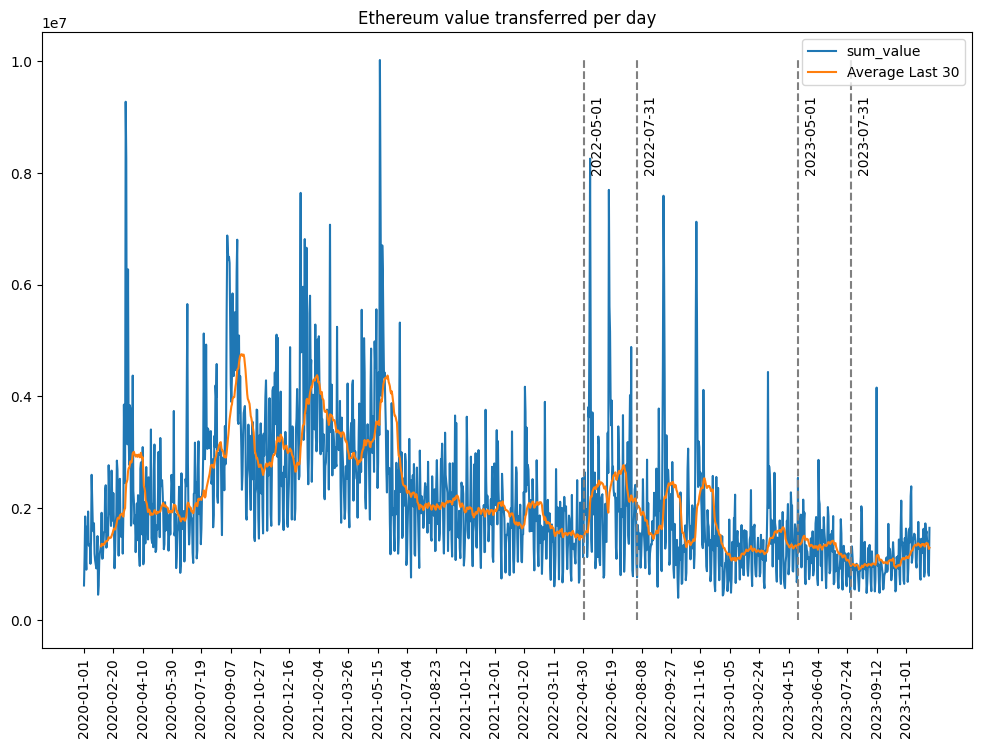

In [205]:
show_metric('sum_value', 'Ethereum value transferred per day', moving_average=True, label_height=0.8)

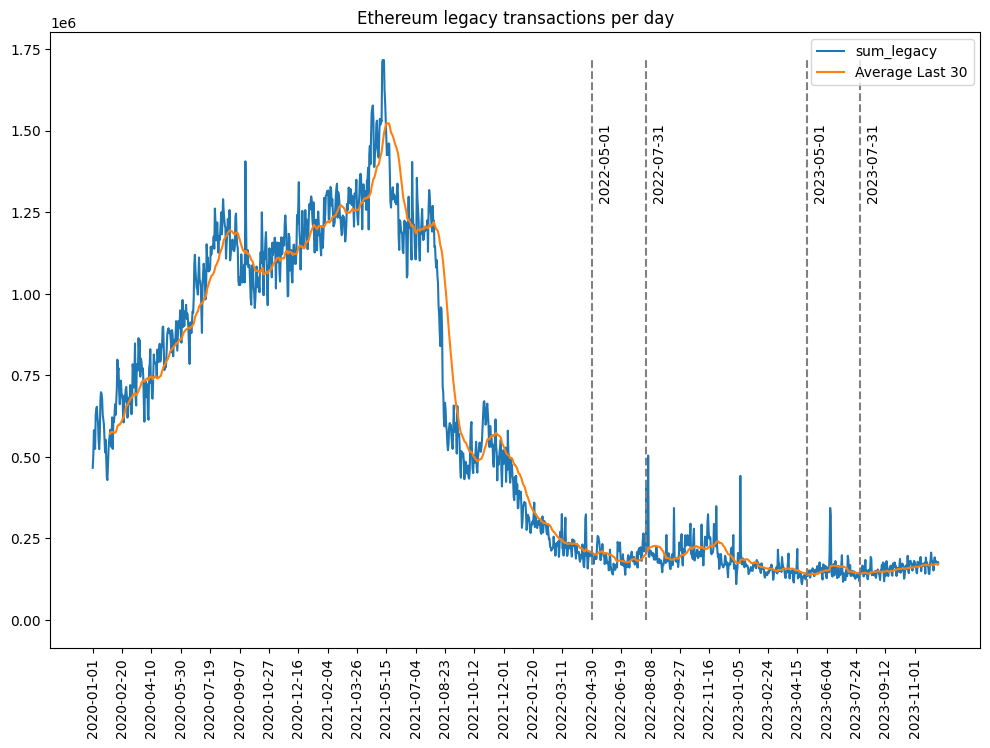

In [206]:
show_metric('sum_legacy', 'Ethereum legacy transactions per day', moving_average=True)

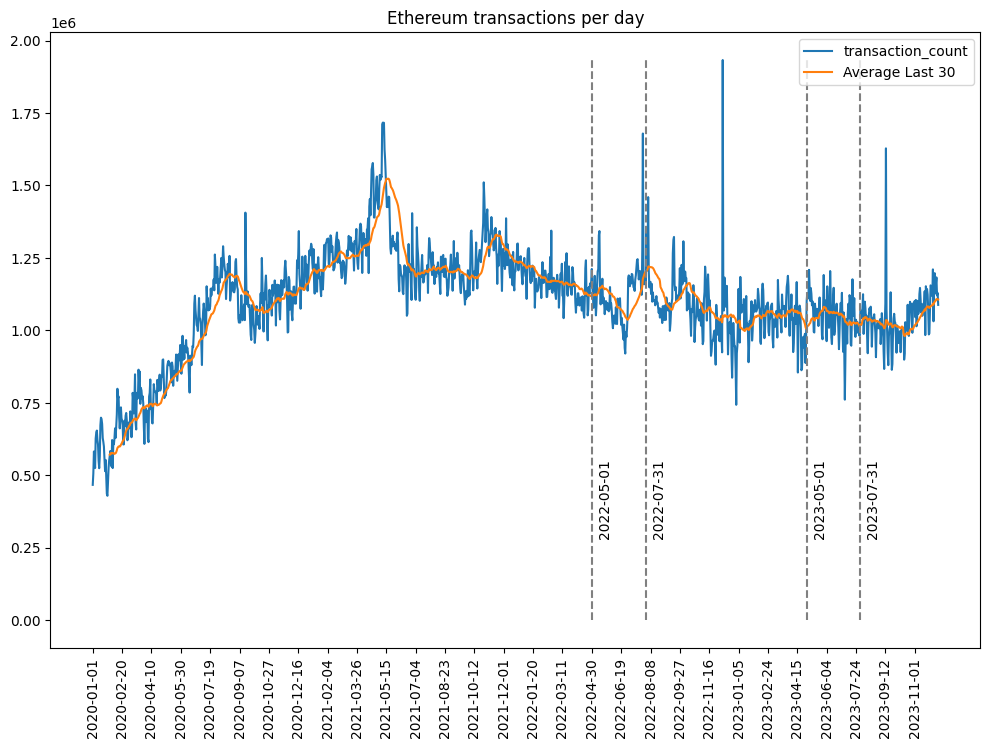

In [207]:
show_metric('transaction_count', 'Ethereum transactions per day', moving_average=True, label_height=0.15)

In [210]:
results['value_per_transaction_avg'] = results['sum_value'] / results['transaction_count']

<ipython-input-210-17b3c7d86562>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['value_per_transaction_avg'] = results['sum_value'] / results['transaction_count']


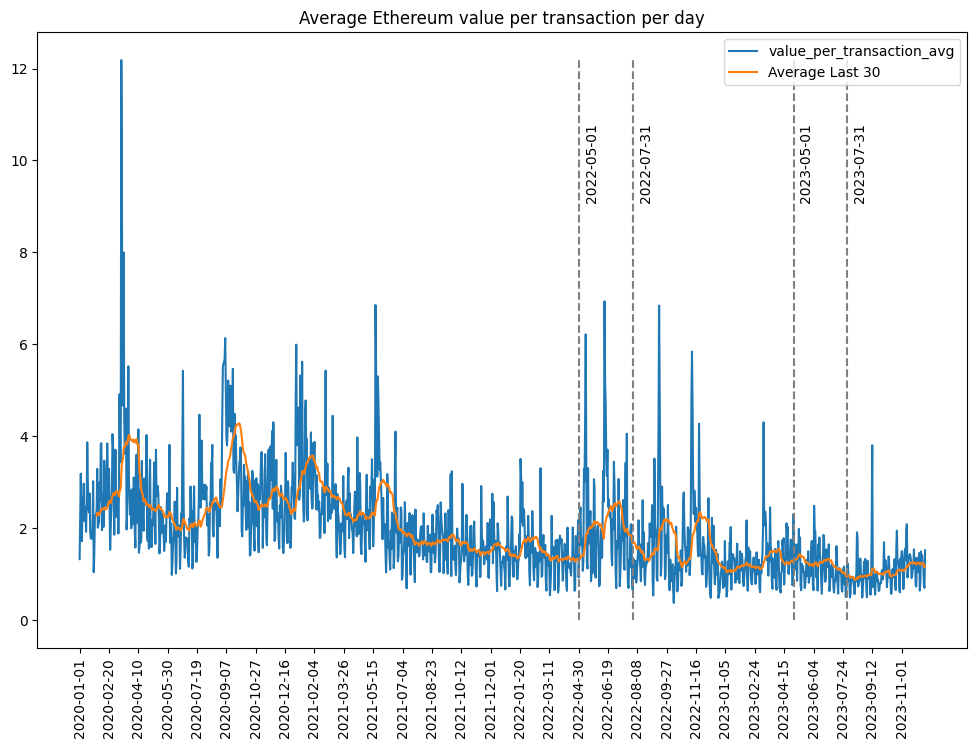

In [213]:
show_metric('value_per_transaction_avg', 'Average Ethereum value per transaction per day', moving_average=True)

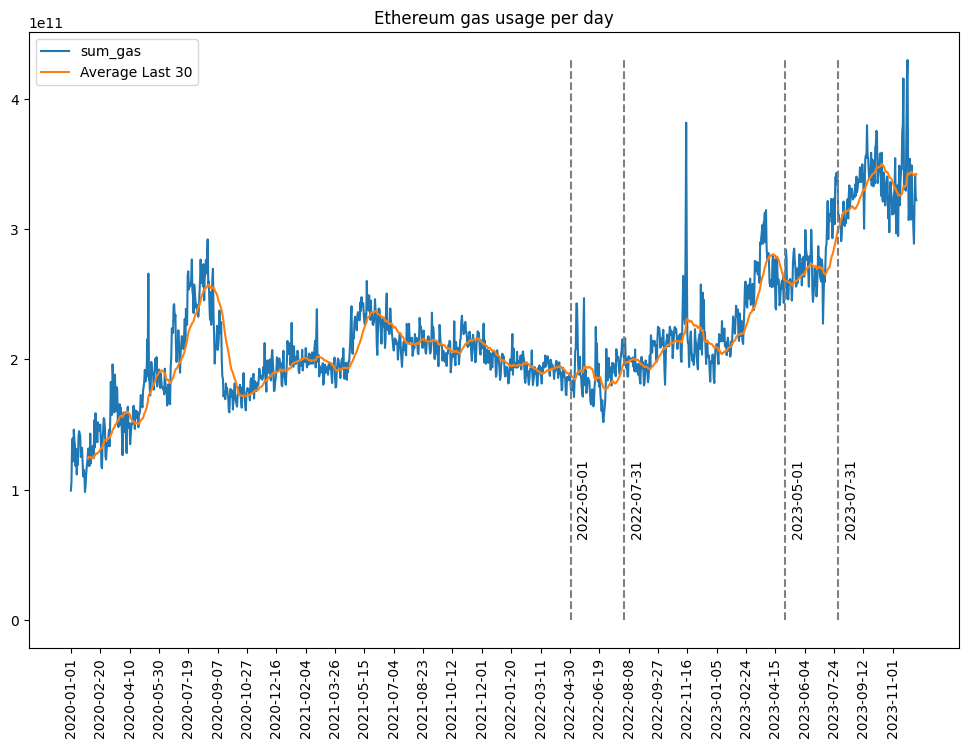

In [208]:
show_metric('sum_gas', 'Ethereum gas usage per day', moving_average=True, label_height=0.15)

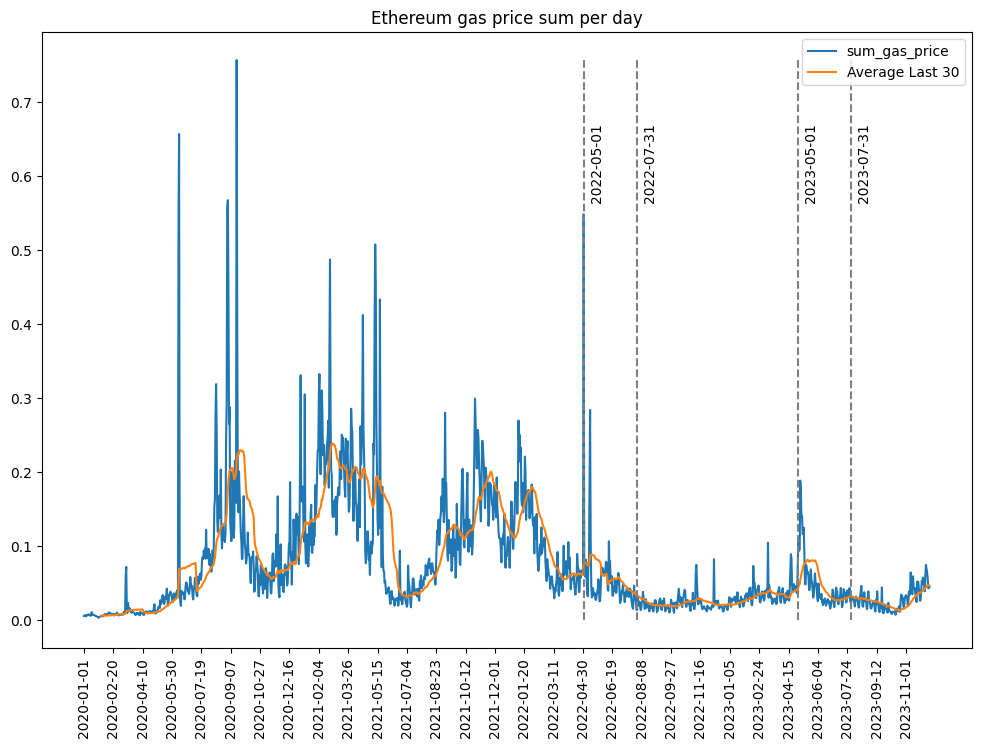

In [209]:
show_metric('sum_gas_price', 'Ethereum gas price sum per day', moving_average=True)